<center>╭────── · · ୨୧ · · ──────╮<br>
         Imports                  <br>
╰────── · · ୨୧ · · ──────╯

In [ ]:
pip install pandas

In [ ]:
import pandas as pd

In [ ]:
!pip install pyspark==3.0.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 9.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044159 sha256=77d5d477f9205c7adfcff71305f50d670ccd0fc1c4c0ddb3194cf0535526ddc9
  Stored in directory: /root/.cache/pip/wheels/b1/bb/8b/ca24d3f756f2ed967225b0871898869db676eb5846df5adc56
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os

In [ ]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession


In [ ]:
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('Instacart Project') \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

In [ ]:
spark

<center>╭────── · · ୨୧ · · ──────╮<br>
        Loading Dataframes                <br>
╰────── · · ୨୧ · · ──────╯

In [ ]:
aisles = spark.read.csv('/content/supermarket_csvs/aisles.csv', header=True, inferSchema=True)
departments = spark.read.csv('/content/supermarket_csvs/departments.csv', header=True, inferSchema=True)
products = spark.read.csv('/content/supermarket_csvs/products.csv', header=True, inferSchema=True)
orders = spark.read.csv('/content/supermarket_csvs/orders.csv', header=True, inferSchema=True)
priors = spark.read.csv('/content/supermarket_csvs/order_products__prior.csv', header=True, inferSchema=True)
# trains = spark.read.csv('/content/supermarket_csvs/order_products__train.csv', header=True, inferSchema=True)
# samples = pd.read_csv('/content/supermarket_csvs/sample_submission.csv')

<center>╭────── · · ୨୧ · · ──────╮<br>
         Contexto                  <br>
╰────── · · ୨୧ · · ──────╯

O Instacart é uma rede de lojas de conveniência online, eles possuim uma variedade de produtos como: Lanches, cosméticos, produtos para pets, etc.
<br>No ano de 2017 eles organizaram uma competição no Kaggle, lançando pela primeira vez um de seus datasets com mais de 3 milhões de samples de pedidos dos usuários. O objetivo desta competição era prever quais produtos os usuários iriam pedir **novamente**.
<br>


<center>╭────── · · ୨୧ · · ──────╮<br>
        Dataframes overview               <br>
╰────── · · ୨୧ · · ──────╯

♡ Aisles (Alas)
<br>🗝️`aisle_id:` Identificação única parra cada ala do supermercado.
<br>`aisle:` Nome da ala, ex.: Suplementos vitamínicos, comidas instantâneas, papelaria...

In [ ]:
aisles.sample(withReplacement=False, fraction=0.1, seed=42).limit(3).show()

+--------+------------------+
|aisle_id|             aisle|
+--------+------------------+
|       8|   bakery desserts|
|      17|baking ingredients|
|      19|     oils vinegars|
+--------+------------------+



In [ ]:
aisles.printSchema()

root
 |-- aisle_id: integer (nullable = true)
 |-- aisle: string (nullable = true)



♡ Departments (departamentos)
<br>🗝️`department_id:` Identificação única para cada departamento do supermercado.
<br>`department:` Nome do departamento, ex.: Pets, café da manhã, bebidas, bebês...

*Obs.: Os departamentos são a classificação geral, enquanto aisles são os corredores, se referem mais a localização de um produto do que seu setor.*

In [ ]:
departments.sample(withReplacement=False, fraction=0.1, seed=42).limit(3).show()


+-------------+----------+
|department_id|department|
+-------------+----------+
|            8|      pets|
|           17| household|
|           19|    snacks|
+-------------+----------+



In [ ]:
departments.printSchema()

root
 |-- department_id: integer (nullable = true)
 |-- department: string (nullable = true)



♡ Orders (pedidos)
<br>🗝️`order_id:` Identificação única para cada departamento do supermercado.
<br>`user_id:` Identificação única para cada usuário.
<br>`eval_set:` Determina em qual grupo o pedido pertence: prior, test, train.*
<br>`order_number:` Número do pedido (em ordem) para aquele usuário.
<br>`order_dow:` dow = day of the week. Dia da semana em que o pedido foi feito.
<br>`order_hour_of_day:` Hora do dia em que o pedido foi feito.
<br>`days_since_prior_order:` Quantidade de dias desde o último pedido.


* Observações:<br>
`eval_set:` <br>
Prior ⟶ Comportamentos anteriores dos usuários.
Train & test ⟶ Comportamento futuro necessário para predição.

In [ ]:
orders.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)



A coluna days_since_prior_order é do tipo "double", o que não é ideal. O tipo mais adequado para ela é integer.

In [ ]:
orders.sample(withReplacement=False, fraction=0.1, seed=10).limit(5).show()

+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 1447487|      2|   prior|          10|        1|               11|                   6.0|
| 3186735|      2|   prior|          12|        1|                9|                  28.0|
| 1492625|      2|   train|          15|        1|               11|                  30.0|
| 1374495|      3|   prior|           1|        1|               14|                  null|
|   94891|      4|   prior|           4|        5|               13|                  15.0|
+--------+-------+--------+------------+---------+-----------------+----------------------+



♡ Products (produtos)
<br>🗝️`product_id:` Identificação única para cada produto do supermercado.
<br>`product_name:` Nome do produto.
<br>`aisle_id:` Chave estrangeira para identificar em qual ala o produto está.
<br>`department_id:` Chave estrangeira para identificar a qual departamento o produto pertence.


*Obs.: Os departamentos são a classificação geral, enquanto aisles são os corredores, se referem mais a localização de um produto do que seu setor.*

In [ ]:
products.sample(withReplacement=False, fraction=0.1, seed=42).limit(3).show()

+----------+--------------------+--------+-------------+
|product_id|        product_name|aisle_id|department_id|
+----------+--------------------+--------+-------------+
|         8|Cut Russet Potato...|     116|            1|
|        17|   Rendered Duck Fat|      35|           12|
|        19|Gluten Free Quino...|      63|            9|
+----------+--------------------+--------+-------------+



♡ Priors, trains, tests (anteriores, treinamento e testes)
<br> `add_to_cart_order:` Ordem na qual o produto foi adicionado no carrinho.
<br> `reordered:` Será 1 caso a pessoa já tenha pedido isso antes alguma vez.
<br>
* Priors: Descrevem o comportamento passado de um usuário.
* Trains: Estes referem ao comportamento futuro e servem para treinar o modelo de predição.
* Tests:Também referem-se ao comportamento futuro, mas são usados para avaliar o modelo.


In [ ]:
priors.show(2)

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       2|     33120|                1|        1|
|       2|     28985|                2|        1|
+--------+----------+-----------------+---------+
only showing top 2 rows



<center>╭────── · · ୨୧ · · ──────╮<br>
         Assessing                  <br>
╰────── · · ୨୧ · · ──────╯

In [ ]:
from pyspark.sql.functions import col, sum as spark_sum


In [ ]:
dataframes = [aisles, departments, orders, products]
df_names = ["aisles", "departments", "orders", "products"]

for df, nome in zip(dataframes, df_names):
    print(f"DataFrame: {nome}")

    # Duplicados
    duplicates_count = df.groupBy(df.columns).count().filter(col("count") > 1).count()
    print(f"Número de linhas duplicadas: {duplicates_count}")

    # Nulos
    null_counts = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
    print("Contagem de valores nulos em cada coluna:")
    null_counts.show()

    print("───── ⋆⋅☆⋅⋆ ─────")

DataFrame: aisles
Número de linhas duplicadas: 0
Contagem de valores nulos em cada coluna:
+--------+-----+
|aisle_id|aisle|
+--------+-----+
|       0|    0|
+--------+-----+

───── ⋆⋅☆⋅⋆ ─────
DataFrame: departments
Número de linhas duplicadas: 0
Contagem de valores nulos em cada coluna:
+-------------+----------+
|department_id|department|
+-------------+----------+
|            0|         0|
+-------------+----------+

───── ⋆⋅☆⋅⋆ ─────
DataFrame: orders
Número de linhas duplicadas: 0
Contagem de valores nulos em cada coluna:
+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
|       0|      0|       0|           0|        0|                0|                 82630|
+--------+-------+--------+------------+---------+-----------------+----------------------+

───

image.png

#### Por que existem tantos valores nulos na coluna "days_since_prior_order"?
Isso se deve ao fato de que os valores desta coluna representam a quantidade de dias que se passaram desde o último pedido daquele usuário. Os valores são nulos quando ele efetua seu primeiro pedido. Por agora irei mantê-los como nulos.

<center>╭────── · · ୨୧ · · ──────╮<br>
        Cleaning               <br>
╰────── · · ୨୧ · · ──────╯

In [ ]:
from pyspark.sql.functions import when

In [ ]:
# A coluna de orders_dow (day of the week) representa dias da semana porém esses dias estão
#sendo representados por números. Isso pode ser extremamente confuso, por isso devemos
#substituir os números pelos seus dias correspondentes.
orders = orders.withColumn("order_dow", when(orders["order_dow"] == 0, "Sáb") \
                                       .when(orders["order_dow"] == 1, "Dom") \
                                       .when(orders["order_dow"] == 2, "Seg") \
                                       .when(orders["order_dow"] == 3, "Ter") \
                                       .when(orders["order_dow"] == 4, "Qua") \
                                       .when(orders["order_dow"] == 5, "Qui") \
                                       .when(orders["order_dow"] == 6, "Sex"))

In [ ]:
# Filtrando o dataframe de pedidos apenas para pedidos realmente efetuados na plataforma instacart.
orders = orders.filter(orders.eval_set == "prior")

In [ ]:
# Convertendo dados para tipos adequados.
orders = orders.withColumn("days_since_prior_order", col("days_since_prior_order").cast("integer"))
orders.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: string (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: integer (nullable = true)



In [ ]:
# Converter a coluna 'department_id' para o tipo integer
products = products.withColumn("department_id", products["department_id"].cast("integer"))
products.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |-- department_id: integer (nullable = true)



In [ ]:
# E a coluna isle_id também
products = products.withColumn("aisle_id", products["aisle_id"].cast("integer"))
products.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: integer (nullable = true)
 |-- department_id: integer (nullable = true)



<center>╭────── · · ୨୧ · · ──────╮<br>
        Plotting               <br>
╰────── · · ୨୧ · · ──────╯

In [ ]:
from pyspark.sql.functions import count
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

In [ ]:
orders_by_dow = orders.groupBy("order_dow").count().orderBy("count")
orders_by_dow.show()

+---------+------+
|order_dow| count|
+---------+------+
|      Qua|161041|
|      Ter|165590|
|      Sex|168675|
|      Qui|171512|
|      Seg|177993|
|      Sáb|223612|
|      Dom|224186|
+---------+------+



In [ ]:
orders_by_dow_pd = orders_by_dow.toPandas()

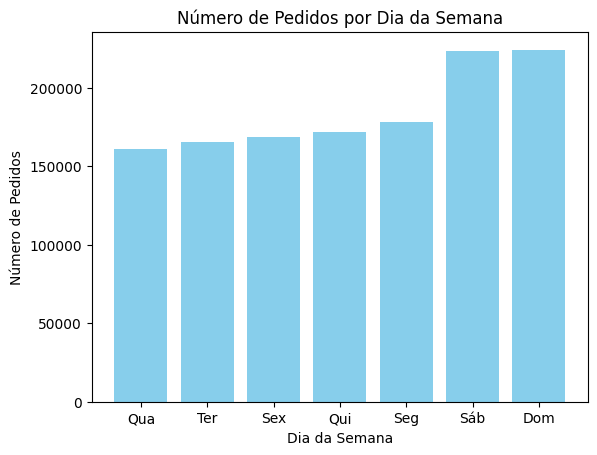

In [ ]:
plt.bar(orders_by_dow_pd["order_dow"], orders_by_dow_pd["count"], color='skyblue')
plt.xlabel('Dia da Semana')
plt.ylabel('Número de Pedidos')
plt.title('Número de Pedidos por Dia da Semana')
plt.show()

In [ ]:
#Embora não possa ter certeza sobre quais números representam quais dias, pelas minhas pesquisas
#0s e 1s representam os dias do fim de semana.

<center>
˗ˏˋ ★ ˎˊ˗

Decisão 1: Testes de carga.

Visto que o Instacart tem maior número de pedidos durante os fins de semana, é importante que o aplicativo (ou site) seja capaz de lidar com essa demanda. Por isso, **testes de carga devem ser efetuados** para garantir que a plataforma consiga lidar com um alto número de acessos simultâneos. Caso ocorram problemas, isso pode levar à insatisfação dos clientes.


</center>

In [ ]:
orders_by_hour = orders.groupBy("order_hour_of_day").agg(count("order_id").alias("count")).orderBy("order_hour_of_day")

In [ ]:
orders_by_hour_pd = orders_by_hour.toPandas()

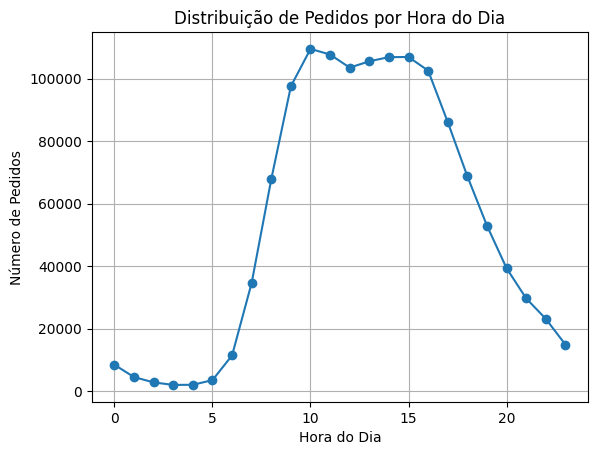

In [ ]:
plt.plot(orders_by_hour_pd["order_hour_of_day"], orders_by_hour_pd["count"], marker='o')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Pedidos')
plt.title('Distribuição de Pedidos por Hora do Dia')
plt.grid(True)
plt.show()

<center>
˗ˏˋ ★ ˎˊ˗

Decisão 2: Notificações.

A maioria dos pedidos é efetuada entre **10h e 15h, que tal enviar notificações pelo aplicativo móvel durante esse período?** Isso pode aumentar o engajamento e incentivar mais compras, aproveitando o horário de maior atividade dos clientes.

</center>

         Frequência de Pedidos  Tempo Último Pedido
user_id                                            
1                           10                 30.0
2                           14                 13.0
3                           12                 15.0
4                            5                  0.0
5                            4                 19.0
...                        ...                  ...
82626                        7                 13.0
82627                        4                  7.0
82628                        5                 30.0
82629                        4                  8.0
82630                        3                 12.0

[82630 rows x 2 columns]


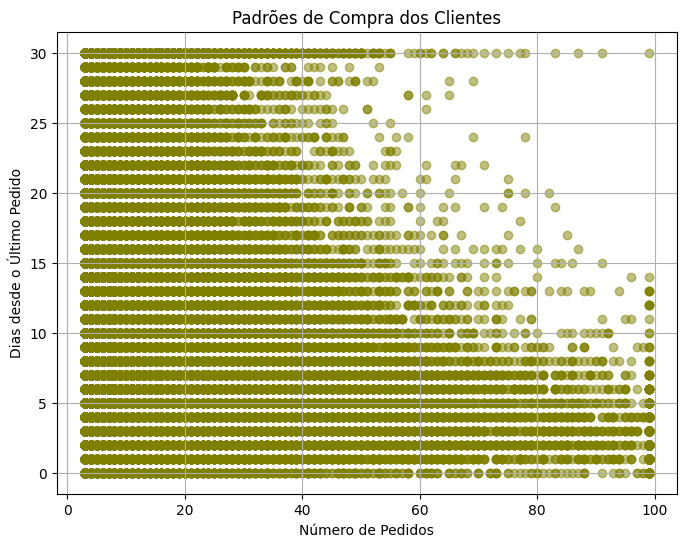

In [ ]:
orders_pandas= orders.toPandas()

frequencia_pedidos = orders_pandas.groupby('user_id').size()

tempo_ultimo_pedido = orders_pandas.groupby('user_id')['days_since_prior_order'].last()

tabela_frequencia = pd.DataFrame({'Frequência de Pedidos': frequencia_pedidos, 'Tempo Último Pedido': tempo_ultimo_pedido})
print(tabela_frequencia)

plt.figure(figsize=(8, 6))
plt.scatter(frequencia_pedidos, tempo_ultimo_pedido, color='olive', alpha=0.5)
plt.title('Padrões de Compra dos Clientes')
plt.xlabel('Número de Pedidos')
plt.ylabel('Dias desde o Último Pedido')
plt.grid(True)
plt.show()


<center>
˗ˏˋ ★ ˎˊ˗

Decisão 3: Cupons para clientes assíduos.

Para manter os clientes mais engajados nas compras, é interessante oferecer benefícios especiais aos clientes que compram com mais frequência na plataforma, incentivando-os a continuarem a utilizar os serviços do instacart regularmente.

</center>

In [ ]:
# Juntado priors com products.
join_priors_products = priors.join(products, on='product_id')
join_priors_products.show(5)

+----------+--------+-----------------+---------+--------------------+--------+-------------+
|product_id|order_id|add_to_cart_order|reordered|        product_name|aisle_id|department_id|
+----------+--------+-----------------+---------+--------------------+--------+-------------+
|     33120|       2|                1|        1|  Organic Egg Whites|      86|           16|
|     28985|       2|                2|        1|Michigan Organic ...|      83|            4|
|      9327|       2|                3|        0|       Garlic Powder|     104|           13|
|     45918|       2|                4|        1|      Coconut Butter|      19|           13|
|     30035|       2|                5|        0|   Natural Sweetener|      17|           13|
+----------+--------+-----------------+---------+--------------------+--------+-------------+
only showing top 5 rows



In [ ]:
# Juntando o novo dataframe com departmentes para pegar os nomes.
join_orders_departments = join_priors_products.join(departments, on='department_id')
join_orders_departments.show(5)

+-------------+----------+--------+-----------------+---------+--------------------+--------+----------+
|department_id|product_id|order_id|add_to_cart_order|reordered|        product_name|aisle_id|department|
+-------------+----------+--------+-----------------+---------+--------------------+--------+----------+
|           16|     33120|       2|                1|        1|  Organic Egg Whites|      86|dairy eggs|
|            4|     28985|       2|                2|        1|Michigan Organic ...|      83|   produce|
|           13|      9327|       2|                3|        0|       Garlic Powder|     104|    pantry|
|           13|     45918|       2|                4|        1|      Coconut Butter|      19|    pantry|
|           13|     30035|       2|                5|        0|   Natural Sweetener|      17|    pantry|
+-------------+----------+--------+-----------------+---------+--------------------+--------+----------+
only showing top 5 rows



In [ ]:
# Agrupando os dados por departamento e contando o total de vendas em cada um
total_vendas_por_departamento = join_orders_departments.groupBy('department').agg(count('order_id').alias('total_vendas'))

# Calculando o total de vendas e qual o percentual de vendas para cada departamento.
total_vendas = total_vendas_por_departamento.selectExpr('sum(total_vendas) as total_vendas').collect()[0]['total_vendas']

total_vendas_por_departamento = total_vendas_por_departamento.withColumn('percentual_vendas', (total_vendas_por_departamento['total_vendas'] / total_vendas) * 100)

# Ordenando em ordem decrescente
total_vendas_por_departamento = total_vendas_por_departamento.orderBy('total_vendas', ascending=False)
total_vendas_por_departamento.show()


+---------------+------------+-------------------+
|     department|total_vendas|  percentual_vendas|
+---------------+------------+-------------------+
|        produce|      750567|  29.19472915894401|
|     dairy eggs|      429107| 16.690931849131374|
|         snacks|      229572|   8.92963900954491|
|      beverages|      213210|  8.293207940101887|
|         frozen|      177671|  6.910851029153616|
|         pantry|      148007|  5.757013402704657|
|         bakery|       93137|  3.622740527729794|
|   canned goods|       84526| 3.2877993262279066|
|           deli|       83542|   3.24952477713049|
|dry goods pasta|       68192| 2.6524573699705822|
|      household|       58476|   2.27453509453308|
|   meat seafood|       56431| 2.1949909350775743|
|      breakfast|       56320|  2.190673379234268|
|  personal care|       35669| 1.3874135078818732|
|         babies|       33966| 1.3211720880516893|
|  international|       21486| 0.8357387824259142|
|        alcohol|       12053| 

In [ ]:
# Ordenando os departamentos com base na porcentagem de vendas em ordem decrescente
total_vendas_por_departamento = total_vendas_por_departamento.orderBy('percentual_vendas', ascending=False)

# Calculando a porcentagem acumulada de vendas
w = Window.orderBy(F.desc('percentual_vendas'))
total_vendas_por_departamento = total_vendas_por_departamento.withColumn('porcentagem_acumulada', F.sum('percentual_vendas').over(w))


df_vendas_por_departamento = total_vendas_por_departamento.toPandas()


<ipython-input-49-a943032aea19>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10_departamentos['porcentagem_acumulada'] = df_top_10_departamentos['percentual_vendas'].cumsum()


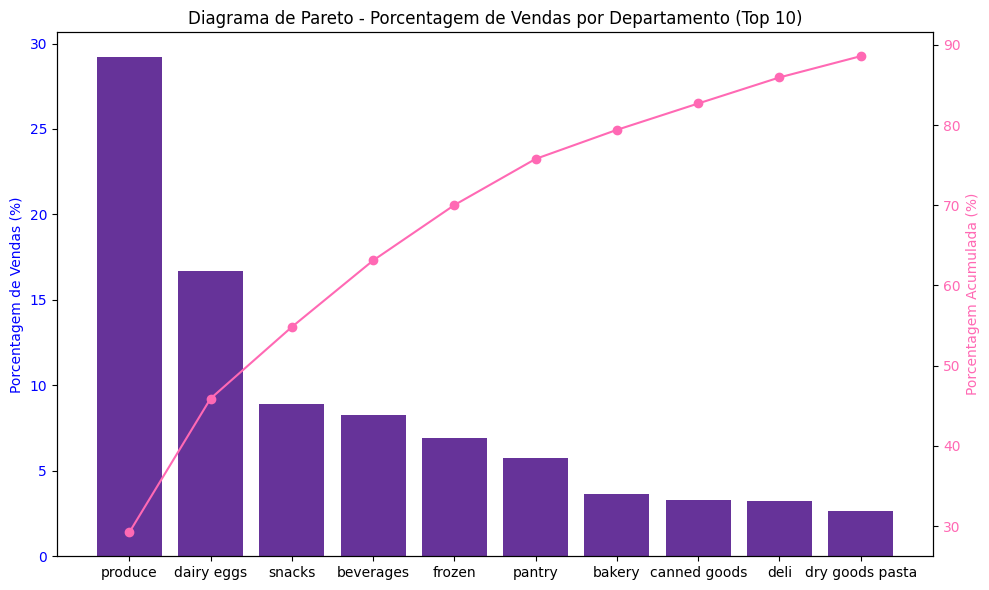

In [ ]:
# Organizando em ordem descrescenete.
df_vendas_por_departamento = df_vendas_por_departamento.sort_values(by='percentual_vendas', ascending=False)
# Aqui filtrei somente os 10 porque não consegui ajustar os nomes nas barras para ficar legíveis.
df_top_10_departamentos = df_vendas_por_departamento.head(10)

df_top_10_departamentos['porcentagem_acumulada'] = df_top_10_departamentos['percentual_vendas'].cumsum()

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(df_top_10_departamentos['department'], df_top_10_departamentos['percentual_vendas'], color='rebeccapurple')
ax1.set_ylabel('Porcentagem de Vendas (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df_top_10_departamentos['department'], df_top_10_departamentos['porcentagem_acumulada'], color='hotpink', marker='o')
ax2.set_ylabel('Porcentagem Acumulada (%)', color='hotpink')
ax2.tick_params(axis='y', labelcolor='hotpink')

plt.xlabel('Departamento')
plt.title('Diagrama de Pareto - Porcentagem de Vendas por Departamento (Top 10)')

plt.tight_layout()
plt.show()


<center>
˗ˏˋ ★ ˎˊ˗
 Decisão 4: Destaque para departamentos líderes.

Analisando o diagrama de Pareto, notamos que os departamentos "produce" e "dairy eggs" são os mais populares no Instacart, representando a maior parte das vendas. Portanto, é crucial investir em estratégias para destacar essas categorias, como promoções especiais e parcerias com marcas reconhecidas.
</center>

In [ ]:

freq_table = orders.groupBy("order_dow").count()

total_orders = freq_table.agg(F.sum("count")).collect()[0][0]
freq_table = freq_table.withColumn("relative_frequency", (F.col("count") / total_orders) * 100)

freq_table = freq_table.withColumn("relative_frequency", F.round("relative_frequency", 1))

freq_table.show()


+---------+------+------------------+
|order_dow| count|relative_frequency|
+---------+------+------------------+
|      Qua|161041|              12.5|
|      Sáb|223612|              17.3|
|      Ter|165590|              12.8|
|      Qui|171512|              13.3|
|      Seg|177993|              13.8|
|      Dom|224186|              17.3|
|      Sex|168675|              13.0|
+---------+------+------------------+



<center>
˗ˏˋ ★ ˎˊ˗
Decisão 5: Promoções estratégicas.

Apesar dos picos de vendas nos fins de semana, observa-se uma demanda significativa em outros dias da semana. Estes dias onde atualmente os pedidos são feitos com menos frequência podem ter ofertas para

</center>